# Pneumonia detection using chest x-rays

## Overview

Pneumonia infections lead to inflamed lungs and are caused by either bacteria or a virus. It can be quite serious, especially in young children and adults over 65. More than 40,000 people die of pneumonia each year. Early treatment can lead to better outcomes, so quick, easily available diagnostics are important to improve survival rates.

### Business Problem

Pulmonologists at a local hospital would like to improve their ability to quickly and accurately determine the origin of pneumonia. The origin of pneumonia dictates treatment methods, but the methods used to determine the origin either take time or are expensive. Chest x-rays are commonly used to diagnose an infection but cannot be used to determine the origin of the infection with the naked eye. Thus, training a model to recognize the difference in infection origin in x-rays would save time and money. The first step in this process is to train a model to recognize the difference between normal and infected lungs on chest x-rays.

### Data Understanding

Image files of chest x-rays from patients with normal and pneumonia infected lungs were obtained from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). There are three folders containing training, testing and validation sets. Each set has two subfolders dividing the x-rays into 'Normal' or 'Pneumonia' classes. There are 5216 training images, 624 test images and 16 validation images. 

## Data Preparation

I first import the libraries needed for this project, connect this notebook to my Google Drive and then load the data into my Google Drive.

In [1]:
# Import the needed libraries

import pandas as pd
import numpy as np
import os
import cv2
import pickle

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive, files


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Connent to google drive, where the files are stored
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Connect to the directory holding my utils.py file
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [4]:
# Import utils
import utils as ut

In [ ]:
# Set the kaggle configuration directory and change directories to it

#os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/kaggle_datasets'
#%cd /content/gdrive/MyDrive/kaggle_datasets/

In [ ]:
# Download the data from Kaggle

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# Create a new directory and move the new data into it

#!mkdir pneumonia
#!mv chest-xray-pneumonia.zip pneumonia

In [ ]:
# Change to the new directory and unzip the data

#%cd pneumonia/
#!unzip chest-xray-pneumonia.zip

In [ ]:
# Remove the zip file

#!rm chest-xray-pneumonia.zip

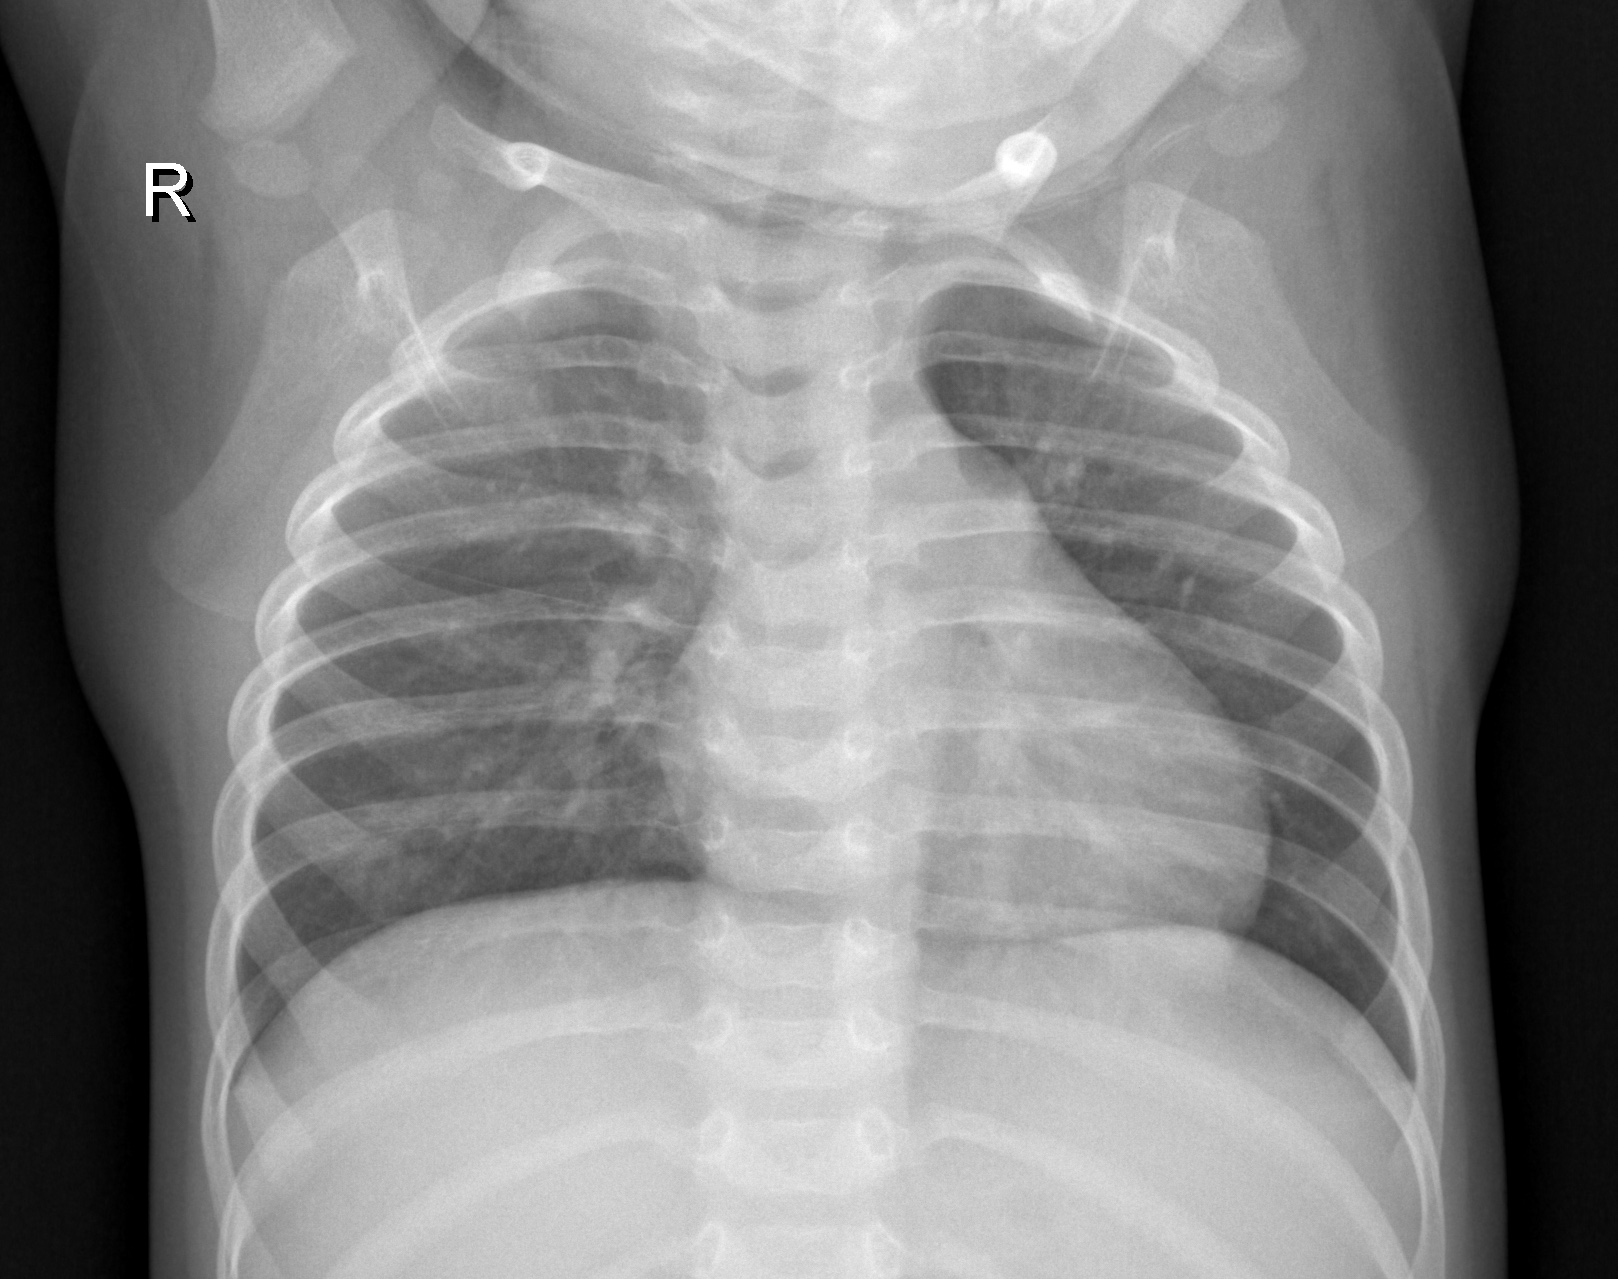

In [ ]:
# View images in the directory 

# First a normal one
img = cv2.imread('/content/gdrive/MyDrive/kaggle_datasets/pneumonia/chest_xray/train/NORMAL/IM-0122-0001.jpeg')
cv2_imshow(img)

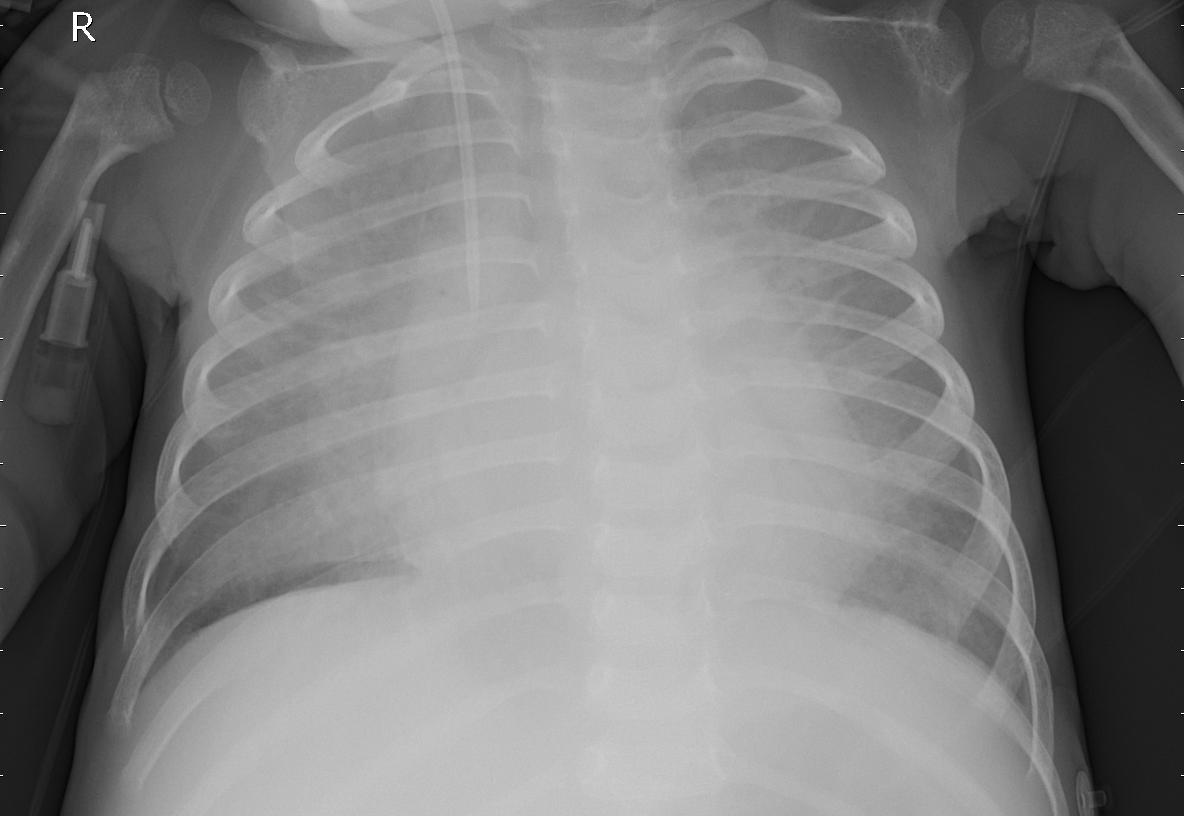

In [ ]:
# And one from the PNEUMONIA directory

img_pneu = cv2.imread('/content/gdrive/MyDrive/kaggle_datasets/pneumonia/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')
cv2_imshow(img_pneu)

In [ ]:
# Check the size/shape of the images

print(img.shape, img_pneu.shape)

(1279, 1618, 3) (816, 1184, 3)


It looks like the images are RGB with varying image heights and widths.

Next, I create DirectoryIterator objects for each of the datasets (training, test, validation) to feed the images into models.

In [5]:
# Define the paths to data in Google Drive

train_path = '/content/gdrive/MyDrive/kaggle_datasets/pneumonia/chest_xray/train'
test_path = '/content/gdrive/MyDrive/kaggle_datasets/pneumonia/chest_xray/test'
val_path = '/content/gdrive/MyDrive/kaggle_datasets/pneumonia/chest_xray/val'

In [6]:
# Instantiate ImageDataGenerator

idg_train = ImageDataGenerator(rescale=1./255)
idg_test = ImageDataGenerator(rescale=1./255)
idg_val = ImageDataGenerator(rescale=1./255)

In [7]:
# Create DirectoryIterators with a binary classification of Normal/Pneumonia

# Define the number of images to feed into the model at a time
batch_size = 64

# Create the DirectoryIterators
train_set = idg_train.flow_from_directory(train_path, 
                                          target_size=(128, 128),  
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          seed=10)
test_set = idg_test.flow_from_directory(test_path, 
                                        target_size=(128, 128), 
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False,
                                        seed=10)
val_set = idg_val.flow_from_directory(val_path, 
                                      target_size=(128, 128), 
                                      batch_size=4,
                                      class_mode='binary',
                                      shuffle=False,
                                      seed=10)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

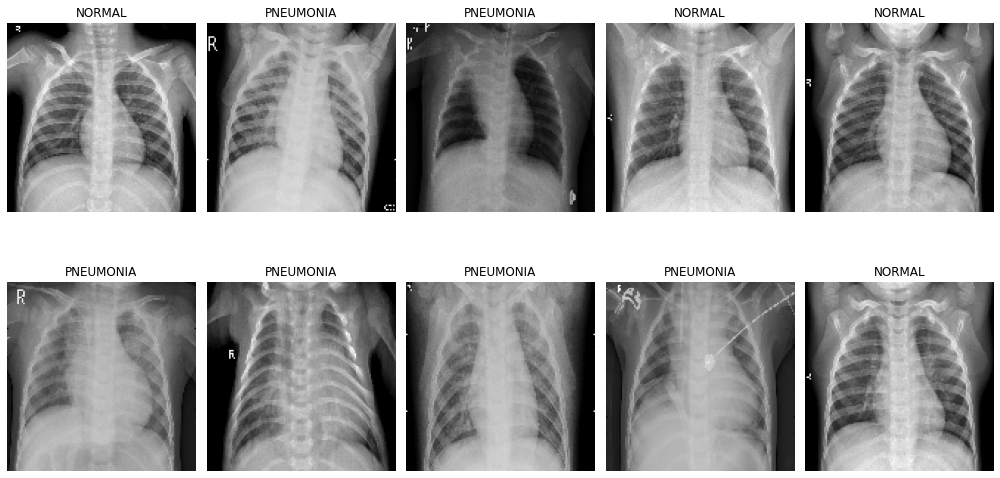

In [ ]:
# View some of the images in the training set

plt.figure(figsize=(14, 8))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    for X_batch, Y_batch in train_set:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(image)
        break
plt.tight_layout()
#plt.savefig('labeled_xrays.png')
#files.download('labeled_xrays.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

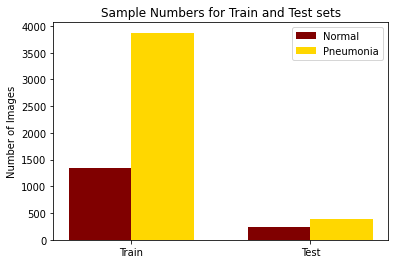

In [ ]:
# Look at sample balance/imbalance

# Define the endings of the directory paths to separate the files into pneumonia/normal
pneumonia = 'PNEUMONIA'
normal = 'NORMAL'

# Determine the length of the directories holding the normal and pneumonia train and test images
train_norm = len(os.listdir(os.path.join(train_path, normal)))
train_pneu = len(os.listdir(os.path.join(train_path, pneumonia)))
test_norm = len(os.listdir(os.path.join(test_path, normal)))
test_pneu = len(os.listdir(os.path.join(test_path, pneumonia)))


# Plot the number of images in each directory
x_labels = ['Train', 'Test']
norm_imgs = [train_norm, test_norm]
pneu_imgs = [train_pneu, test_pneu]

fig, ax = plt.subplots()
x = np.arange(len(x_labels)) 
ax.bar(x-.35/2, norm_imgs, width=0.35, label="Normal", color='maroon')
ax.bar(x+0.35/2, pneu_imgs, width=0.35, label="Pneumonia", color='gold')

ax.set_ylabel('Number of Images')
ax.set_title('Sample Numbers for Train and Test sets')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

#plt.savefig('data-imbalance-bargraph.png')
#files.download('data-imbalance-bargraph.png')
plt.show()


In [ ]:
# Check the shape and max/min values of a batch of train images

batchX, batchy = train_set.next()
print(f'Batch shape={batchX.shape}, min={batchX.min()}, max={batchX.max()}')

Batch shape=(64, 128, 128, 3), min=0.0, max=1.0


## Data Modeling & Evaluation

Convolutional neural networks (CNN) are the go to type of modeling for image data. I will first create a function that will return a basic CNN and that can be modified as I tweak the model.

In [8]:
#CNN 
def cnn_basic(dropout=False, optimizer='adam', loss='binary_crossentropy'):
    '''
       Returns a compiled convolutional neural network.

        Parameters:
                dropout (boolean): True adds 4 dropout layers throughout the model 
                optimizer (string): optimizer to use in compiling the model, 
                                    default is 'adam'
                loss (string): loss function to use in compiling the model, 
                               default is 'binary_crossentropy' 
    '''
    # Instantiate model and add convolutional layers
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout == True:
      model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout == True:
      model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout == True:
      model.add(Dropout(0.25))

    # Add output layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    if dropout == True:
      model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    # Compile and return the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [9]:
# To account for class imbalance, I will add class weights when fitting the model

# Use sklearn class_weight to determine class weights based on the 
# number of images in each class
weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_set.classes), 
                train_set.classes)

# Create class_weights dictionary for the model
class_weights = dict(zip(np.unique(train_set.classes), np.round(weights*100)))

# Verify that weights are in proper format and seem correct
print(class_weights)

{0: 194.0, 1: 67.0}


### Model 1: Basic Convolutional Neural Network

Now that everything is set up, I will create and train the first model.

In [ ]:
# Create a basic CNN model and print its summary
model_1 = cnn_basic()
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [ ]:
# Fit the model to the training DirectoryIterator
# The steps_per_epoch is the number of images in the set divided by the batch size
# This ensures that all images are used for training and keeps the model from
# looping over all the images endlessly (same for validation_steps)

history_1 = model_1.fit(train_set,  
                        steps_per_epoch=train_set.n//train_set.batch_size+1, 
                        epochs=25,
                        class_weight=class_weights, 
                        validation_data=test_set, 
                        validation_steps=test_set.n//test_set.batch_size+1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
82/82 [==============================] - 2034s 25s/step - loss: 60.0027 - accuracy: 0.5573 - val_loss: 0.5323 - val_accuracy: 0.8189
Epoch 2/25
82/82 [==============================] - 52s 638ms/step - loss: 16.0959 - accuracy: 0.9399 - val_loss: 0.4701 - val_accuracy: 0.8125
Epoch 3/25
82/82 [==============================] - 51s 635ms/step - loss: 12.2104 - accuracy: 0.9512 - val_loss: 0.4941 - val_accuracy: 0.8253
Epoch 4/25
82/82 [==============================] - 51s 633ms/step - loss: 7.6073 - accuracy: 0.9712 - val_loss: 0.8973 - val_accuracy: 0.8285
Epoch 5/25
82/82 [==============================] - 51s 627ms/step - loss: 7.3400 - accuracy: 0.9759 - val_loss: 1.1821 - val_accuracy: 0.7260
Epoch 6/25
82/82 [==============================] - 51s 625ms/step - loss: 6.8750 - accuracy: 0.9735 - val_loss: 1.1740 - val_accuracy: 0.7724
E

Evalute Model 1

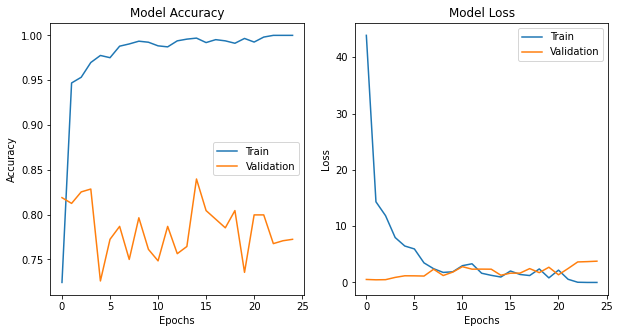

In [ ]:
# Plot the accuracy and loss for the train and test sets over the course of training the model

ut.plot_history(history_1)

This looks like the model is very overfit. The training accuracy increased to 1, while the test accuracy jumped around and with a slight trend of decreasing. Similary, the training loss decreased while the test loss increased.

10/10 [==============================] - 5s 524ms/step - loss: 3.7772 - accuracy: 0.7724
Train Loss:  0.000, Train Accuracy:  1.000
Test Loss:  3.777, Test Accuracy:  0.772
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.98      0.40      0.57       234
   PNEUMONIA       0.73      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624

Confusion Matrix


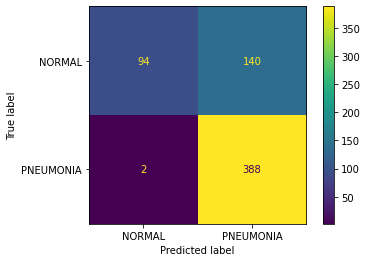

In [ ]:
# Plot a Classification Report and Confusion Matrix for the set

ut.evaluate(model_1, train_set, test_set)

It looks like the model isn't learning much more than to guess the dominant class most of the time. Will take steps to deal with class imbalance and overfitting in the next model.

### Model 2: CNN with Dropout Layers and Data Augmentation 

In this model, I use data augmentation to help improve the class imbalance and add dropout layers to the model to help with overfitting. Additionally, I will use some callbacks to increase model performance by decreasing the learning rate and restoring the best weights at the end of modeling.

In [ ]:
# Deal further with class imbalance by augmenting the dataset using some small 
# shifts in orientation and horizontal flips

# Add shifts and flips to ImageDataGenerator instance
idg_train_aug = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.08, 
                                   height_shift_range=0.08, 
                                   horizontal_flip=True)


# Create new DirectoryIterator with data augmentation
train_set_aug = idg_train_aug.flow_from_directory(train_path, 
                                          target_size = (128, 128),  
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          seed=10)

Found 5216 images belonging to 2 classes.


In [ ]:
# Create new cnn model and include some dropouts to combat over fitting
# View model summary

model_2 = cnn_basic(dropout=True)
model_2.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f153961fbd0>>

In [ ]:
#  Early stopping will allow me to increase the number of epochs. It also has a
# 'restore_best_weights' argument that will restore the weights of the best model 
# after the training ends. The ReduceLROnPlateau will reduce the learning rate 
# when the validation set loss increases twice in a row

# Define the early stopping callback
early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=10, 
                      verbose=1,
                      restore_best_weights = True)

# Define the learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

# Define callback list to use in the models
callbacks_list = [early, learning_rate_reduction]



In [ ]:
# Fit the model using augmented training data, callbacks and increased epochs

history_2 = model_2.fit(train_set_aug, 
                        steps_per_epoch=train_set.n//train_set.batch_size+1, 
                        epochs=50,  
                        class_weight=class_weights,
                        callbacks=callbacks_list,
                        validation_data=test_set, 
                        validation_steps=test_set.n//test_set.batch_size+1)



Epoch 1/50
82/82 [==============================] - 69s 834ms/step - loss: 66.2783 - accuracy: 0.5062 - val_loss: 0.4135 - val_accuracy: 0.8429
Epoch 2/50
82/82 [==============================] - 64s 789ms/step - loss: 36.3383 - accuracy: 0.8426 - val_loss: 0.6406 - val_accuracy: 0.8013
Epoch 3/50
82/82 [==============================] - 64s 786ms/step - loss: 26.2267 - accuracy: 0.8960 - val_loss: 0.5266 - val_accuracy: 0.7821

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/50
82/82 [==============================] - 64s 787ms/step - loss: 15.7948 - accuracy: 0.9436 - val_loss: 0.6217 - val_accuracy: 0.7869
Epoch 5/50
82/82 [==============================] - 64s 788ms/step - loss: 16.0274 - accuracy: 0.9369 - val_loss: 0.6168 - val_accuracy: 0.7965

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/50
82/82 [==============================] - 64s 788ms/step - loss: 12.8978 - accuracy: 0.9518 - val_loss: 0.57

Evaluate Model 2

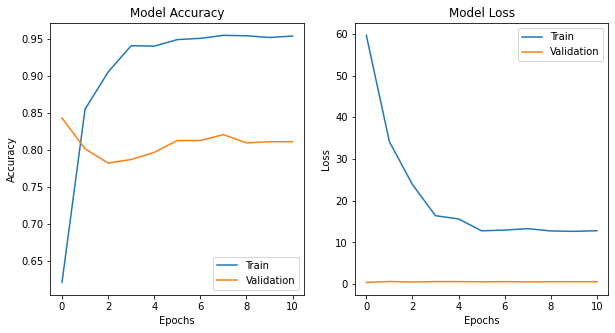

In [ ]:
# Plot the accuracy and loss for the train and test sets over the course of training the model

ut.plot_history(history_2)

This model is still pretty overfit, though this time the training data does not get to an accuracy of 1. 

10/10 [==============================] - 4s 496ms/step - loss: 0.4135 - accuracy: 0.8429
Train Loss:  0.378, Train Accuracy:  0.864
Test Loss:  0.414, Test Accuracy:  0.843
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.80      0.77      0.79       234
   PNEUMONIA       0.87      0.88      0.88       390

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624

Confusion Matrix


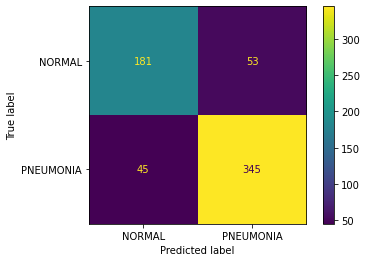

In [ ]:
# Plot a Classification Report and Confusion Matrix for the set

ut.evaluate(model_2, train_set_aug, test_set)

The recall of this model decreased slightly, but the precision looks much better. It is no longer mostly guessing the majority class.

### Model 3: RMSprop Optimizer and Additional Data Augmentation

With this third model, I continue to try to reduce overfitting and get the model to do better with the minority class. 

In [ ]:
# Deal with class imbalance by augmenting the dataset with even more small shifts 
# in orientation and horizontal flips

# Instantiate ImagedataGenerator with shifts and flips
idg_aug_2 = ImageDataGenerator(rescale=1/255,
                                   zoom_range=0.05,
                                   rotation_range=3, 
                                   width_shift_range=0.08, 
                                   height_shift_range=0.08, 
                                   horizontal_flip=True)


# Create DirectoryIterator using new generator
train_set_aug_2 = idg_aug_2.flow_from_directory(train_path, 
                                          target_size = (128, 128),  
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          seed=10)

Found 5216 images belonging to 2 classes.


In [ ]:
# Continue using dropout and try a different optimizer

model_3 = cnn_basic(dropout=True, optimizer='RMSprop')
model_3.summary

In [ ]:
# Fit model with new DirectoryIterator

history_3 = model_3.fit(train_set_aug_2, 
                            steps_per_epoch=train_set.n//train_set.batch_size+1, 
                            epochs=50,  
                            class_weight=class_weights,
                            callbacks=callbacks_list,
                            validation_data=test_set, 
                            validation_steps=test_set.n//test_set.batch_size+1)


Epoch 1/50
82/82 [==============================] - 75s 909ms/step - loss: 79.4305 - accuracy: 0.4526 - val_loss: 0.6722 - val_accuracy: 0.6218
Epoch 2/50
82/82 [==============================] - 70s 864ms/step - loss: 52.7294 - accuracy: 0.6943 - val_loss: 0.6119 - val_accuracy: 0.7051
Epoch 3/50
82/82 [==============================] - 69s 856ms/step - loss: 71.4853 - accuracy: 0.7538 - val_loss: 0.5843 - val_accuracy: 0.7548
Epoch 4/50
82/82 [==============================] - 69s 848ms/step - loss: 44.9860 - accuracy: 0.8232 - val_loss: 0.3377 - val_accuracy: 0.8766
Epoch 5/50
82/82 [==============================] - 68s 842ms/step - loss: 31.6922 - accuracy: 0.8686 - val_loss: 1.0207 - val_accuracy: 0.6763
Epoch 6/50
82/82 [==============================] - 68s 840ms/step - loss: 27.7050 - accuracy: 0.8905 - val_loss: 0.3674 - val_accuracy: 0.8478

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/50
82/82 [==============================] - 68s

Evaluate Model 3

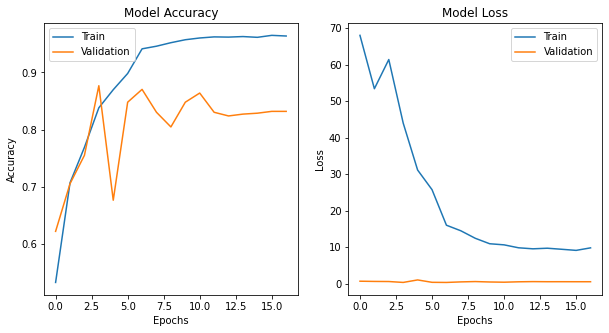

In [ ]:
# Plot the accuracy and loss for the train and test sets over the course of training the model

ut.plot_history(history_3)

This model is still overfit, but less so than the last.

10/10 [==============================] - 5s 584ms/step - loss: 0.3322 - accuracy: 0.8702
Train Loss:  0.221, Train Accuracy:  0.911
Test Loss:  0.332, Test Accuracy:  0.870
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.88      0.75      0.81       234
   PNEUMONIA       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624

Confusion Matrix


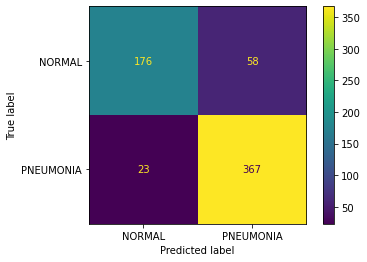

In [ ]:
# Plot a Classification Report and Confusion Matrix for the set

ut.evaluate(model_3, train_set_aug_2, test_set)

Again, the recall has decreased slightly and the precision has increased quite a bit.

### Model 4: Increase Batch Size

Larger batch size can slow the rate of training, but are more stable when they converge ([source](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)). So will try and see if it helps.

In [ ]:
# Increase batch size of both training and testing sets

# Set new batch size
batch_size = 128

# Create new training DirectoryIterator using the generator with high augmentation
train_set_incbatch = idg_aug_2.flow_from_directory(train_path, 
                                          target_size = (128, 128),  
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          seed=10)

# Create new test DirectoryIterator
test_set_incbatch = idg_test.flow_from_directory(test_path, 
                                        target_size=(128, 128), 
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle = False,
                                        seed=10)

# Create new model
model_4 = cnn_basic(dropout=True, optimizer='RMSprop')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Fit model with train and test DirectoryIterators with increased batch size

history_4 = model_4.fit(train_set_incbatch, 
                            steps_per_epoch=train_set.n//train_set_incbatch.batch_size+1, 
                            epochs=50,  
                            class_weight=class_weights,
                            callbacks=callbacks_list,
                            validation_data=test_set_incbatch, 
                            validation_steps=test_set.n//test_set_incbatch.batch_size+1)

Epoch 1/50
41/41 [==============================] - 68s 2s/step - loss: 68.4240 - accuracy: 0.5378 - val_loss: 0.6833 - val_accuracy: 0.4744
Epoch 2/50
41/41 [==============================] - 62s 2s/step - loss: 73.7145 - accuracy: 0.6555 - val_loss: 0.6041 - val_accuracy: 0.6987
Epoch 3/50
41/41 [==============================] - 63s 2s/step - loss: 61.0756 - accuracy: 0.7086 - val_loss: 0.7739 - val_accuracy: 0.7644
Epoch 4/50
41/41 [==============================] - 64s 2s/step - loss: 52.0967 - accuracy: 0.7857 - val_loss: 0.5495 - val_accuracy: 0.7853
Epoch 5/50
41/41 [==============================] - 63s 2s/step - loss: 35.5679 - accuracy: 0.8472 - val_loss: 1.3043 - val_accuracy: 0.6314
Epoch 6/50
41/41 [==============================] - 65s 2s/step - loss: 40.8224 - accuracy: 0.8414 - val_loss: 0.6997 - val_accuracy: 0.7644

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/50
41/41 [==============================] - 63s 2s/step - loss: 2

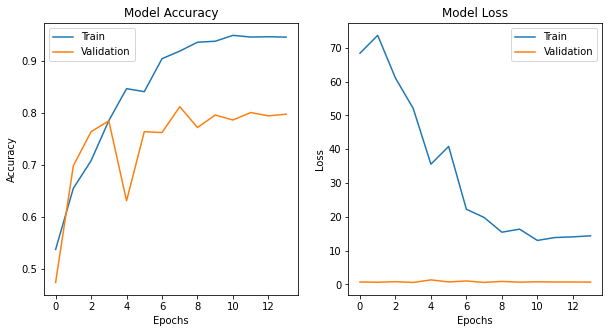

In [ ]:
# Plot the accuracy and loss for the train and test sets over the course of training the model

ut.plot_history(history_4)

Overfitting has increased and the convergence doesn't seem to have improved. 

5/5 [==============================] - 5s 1s/step - loss: 0.5495 - accuracy: 0.7853
Train Loss:  0.521, Train Accuracy:  0.770
Test Loss:  0.549, Test Accuracy:  0.785
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.74      0.66      0.70       234
   PNEUMONIA       0.81      0.86      0.83       390

    accuracy                           0.79       624
   macro avg       0.77      0.76      0.77       624
weighted avg       0.78      0.79      0.78       624

Confusion Matrix


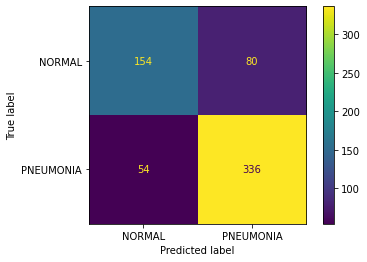

In [ ]:
# Plot a Classification Report and Confusion Matrix for the set

ut.evaluate(model_4, train_set_incbatch, test_set_incbatch)

This model is over all worse than most others, lower accuracy, precision and recall. If I had more time, I would like to see if a smaller batch size would improve the model. 

### Model 5: Pre-trained Model

Finally, I will use to train a pre-trained model with my data and see if it improves performance.

In [ ]:
# Import necessary libraries

from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Input

In [ ]:
# Create a sequential model with the InceptionV3 pre-trained model and an output layer

model_v3 = Sequential()
input_tensor = Input(shape=(128, 128, 3))
model_v3.add(InceptionV3(include_top=False, input_tensor=input_tensor))
model_v3.add(Flatten())
model_v3.add(Dense(1, activation='sigmoid'))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
# Compile the model 

model_v3.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
# The only callback that works with this model is early stopping

# Redefine the callbacks list
callbacks_list = [early]

# Fit the model on the augmented train DirectoryIterator
results_v3 = model_v3.fit(train_set_aug_2, 
                       validation_data=test_set, 
                       epochs=50, 
                       steps_per_epoch=train_set.n//train_set.batch_size+1, 
                       validation_steps=test_set.n//test_set.batch_size+1,
                       callbacks=callbacks_list)

Epoch 1/50
82/82 [==============================] - 2030s 25s/step - loss: 0.3737 - accuracy: 0.8888 - val_loss: 11.2527 - val_accuracy: 0.5513
Epoch 2/50
82/82 [==============================] - 71s 872ms/step - loss: 0.1957 - accuracy: 0.9477 - val_loss: 4240.2778 - val_accuracy: 0.4263
Epoch 3/50
82/82 [==============================] - 69s 854ms/step - loss: 0.2214 - accuracy: 0.9450 - val_loss: 102.5363 - val_accuracy: 0.8205
Epoch 4/50
82/82 [==============================] - 70s 859ms/step - loss: 0.1446 - accuracy: 0.9546 - val_loss: 141.2940 - val_accuracy: 0.6571
Epoch 5/50
82/82 [==============================] - 70s 857ms/step - loss: 0.0970 - accuracy: 0.9688 - val_loss: 1.2518 - val_accuracy: 0.8029
Epoch 6/50
82/82 [==============================] - 69s 856ms/step - loss: 0.1440 - accuracy: 0.9667 - val_loss: 86.5321 - val_accuracy: 0.6474
Epoch 7/50
82/82 [==============================] - 69s 853ms/step - loss: 0.1510 - accuracy: 0.9686 - val_loss: 282.9499 - val_accur

Evaluate Model 5

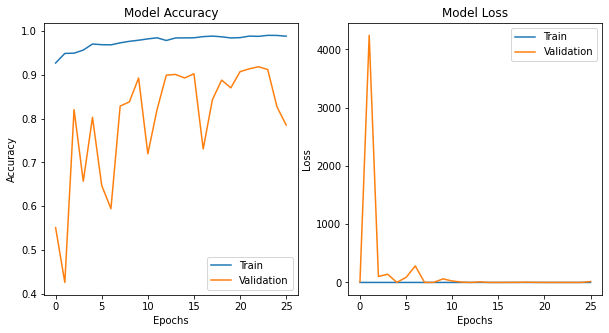

In [ ]:
# Plot the accuracy and loss for the train and test sets over the course of training the model

ut.plot_history(results_v3)

The model is still a bit overfit. The test data does not seem to converge. 

10/10 [==============================] - 5s 547ms/step - loss: 0.2771 - accuracy: 0.9022
Train Loss:  0.040, Train Accuracy:  0.986
Test Loss:  0.277, Test Accuracy:  0.902
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.93      0.80      0.86       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

Confusion Matrix


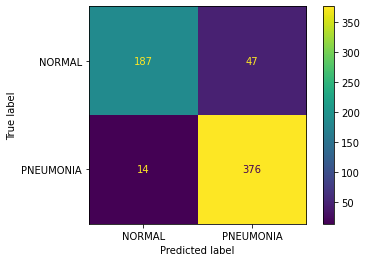

In [ ]:
# Plot a Classification Report and Confusion Matrix for the set

ut.evaluate(model_v3, train_set_aug_2, test_set)

This both recall and precision have increased in this model as compared to the previous models. Best yet! This is the last model for this project, but if I were to continue on, I would like to see the test accuracy converge. To do this, I would first try switching the early stopping to monitor accuracy and maybe increase the patience. 

### Evaluation of Best Model

Finally, I will used the best model (model_v3, from the pre-trained InceptionV3 model) in more detailed evaluation.

4/4 [==============================] - 0s 45ms/step - loss: 0.0858 - accuracy: 0.9375
Train Loss:  0.053, Train Accuracy:  0.985
Test Loss:  0.086, Test Accuracy:  0.938
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.89      1.00      0.94         8
   PNEUMONIA       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix


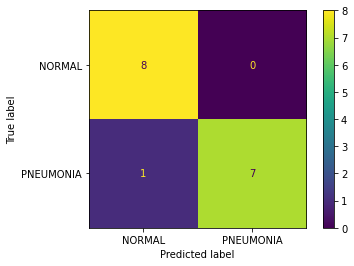

In [ ]:
# Evaluate the model using the hold out validation set

evaluate(model_v3, train_set_aug_2, val_set)

The validation set is very small at only 16 images, but the model did very well! Only one incorrect diagnosis, though it would be better if the incorrect diagnosis was a false positive rather than a false negative.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

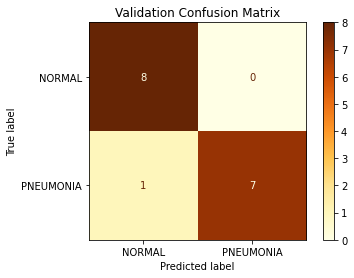

In [ ]:
# Redo the validation data confusion matrix and save it as a png file for use in the 
# presentation and README

val_set.reset()
Y_pred = np.round(model_v3.predict_generator(val_set, val_set.n//val_set.batch_size))
y_pred = Y_pred.tolist()
cm = confusion_matrix(val_set.classes, y_pred)
target_names = list(val_set.class_indices.keys())



disp = ConfusionMatrixDisplay(cm,  display_labels=target_names)
disp.plot(values_format = '', cmap='YlOrBr')
plt.title('Validation Confusion Matrix')
plt.savefig('val-confusionmx.png')
files.download('val-confusionmx.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

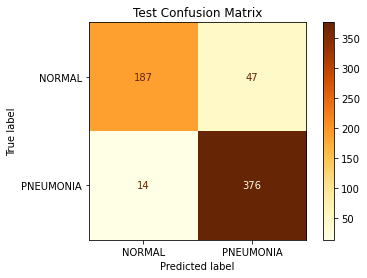

In [ ]:
# Redo the test data confusion matrix and save it as a png file for use in the 
# presentation and README

test_set.reset()
Y_pred = np.round(model_v3.predict_generator(test_set, test_set.n//test_set.batch_size+1))
y_pred = Y_pred.tolist()
cm = confusion_matrix(test_set.classes, y_pred)
target_names = list(test_set.class_indices.keys())



disp = ConfusionMatrixDisplay(cm,  display_labels=target_names)
disp.plot(values_format = '', cmap='YlOrBr')
plt.title('Test Confusion Matrix')
#plt.savefig('test-confusionmx.png')
#files.download('test-confusionmx.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

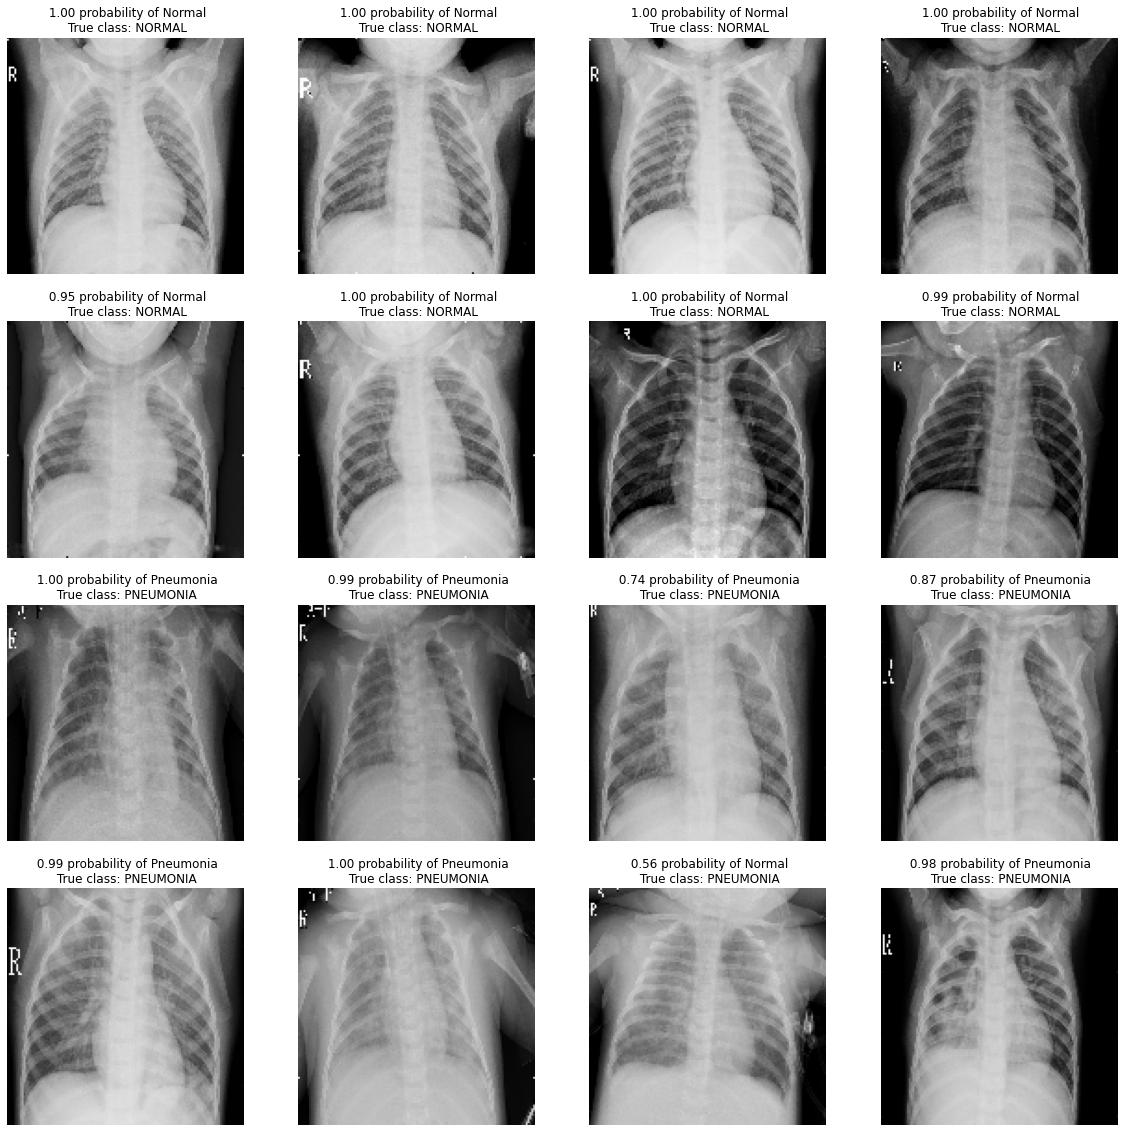

In [ ]:
# Plot validation set x-rays with their predicted and true class

# Create predictions
val_set.reset()
Y_preds = model_v3.predict_generator(val_set, val_set.n//val_set.batch_size+1)
y_preds = Y_preds.tolist()


# Create an image array as x and a label array as y from the DirectoryIterator
val_set.reset()
x=np.concatenate([val_set.next()[0] for i in range(val_set.__len__())])
y=np.concatenate([val_set.next()[1] for i in range(val_set.__len__())])

# Plot images along with their predictions and actual classes
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0, 16):
    plt.subplot(4, 4, (i)+1)
    if y_preds[i][0] >= 0.5: 
      out = (f'{y_preds[i][0]: .2f} probability of Pneumonia')     
    else: 
      out = (f'{1-y_preds[i][0]: .2f} probability of Normal')
    plt.title(out+"\n True class: "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
#plt.savefig('val-xrays.png')
#files.download('val-xrays.png')
plt.show()

The one incorrectly predicted x-ray had a low confidence prediction, while the correctly predicted x-ray classes had high probabilities behind their predictions.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

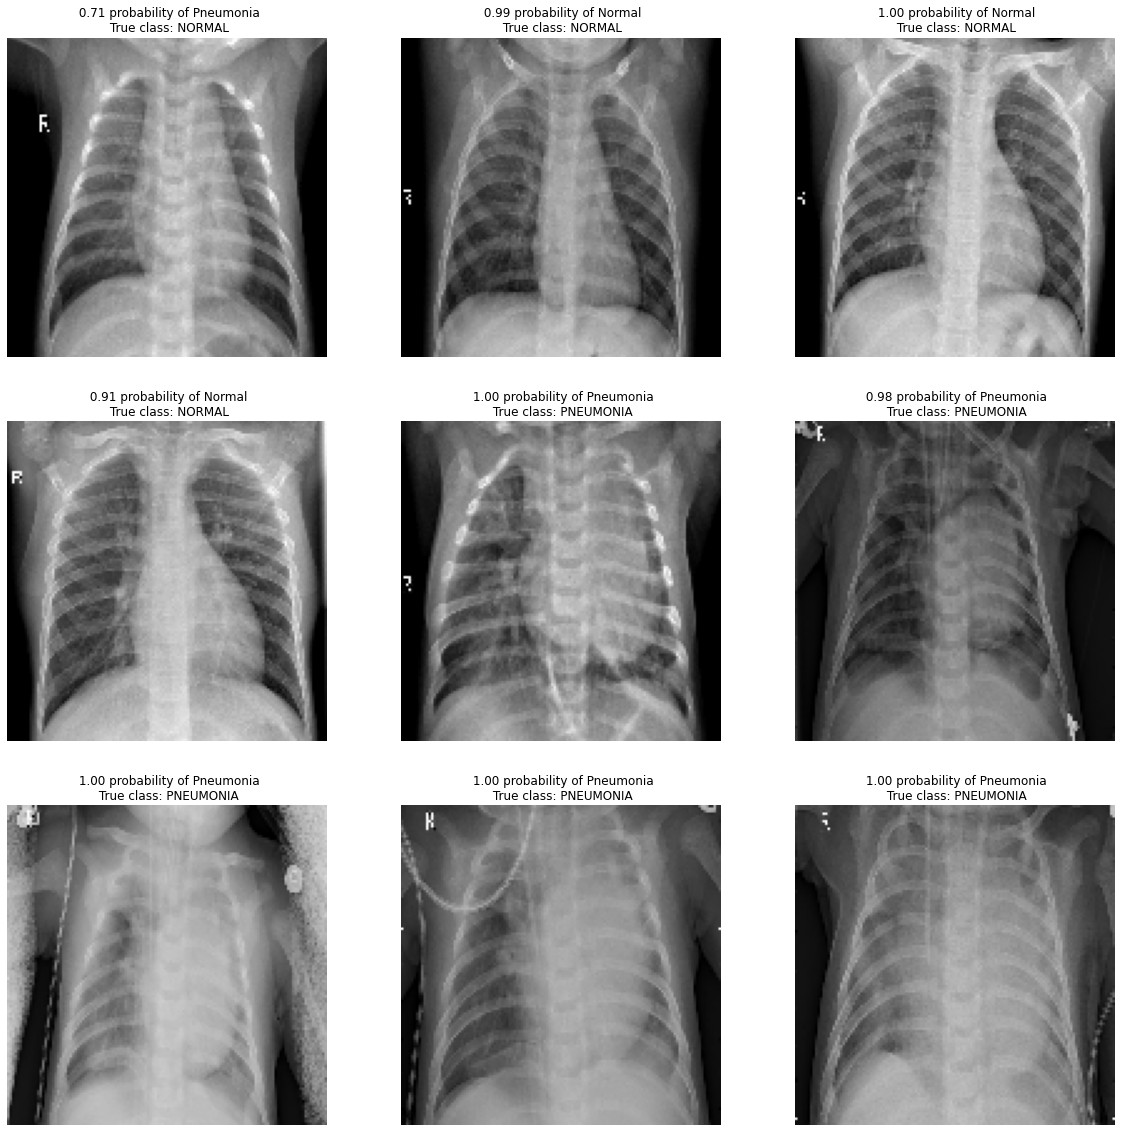

In [ ]:
# Plot test set x-rays with their predicted and true class

# Get predictions
test_set.reset()
Y_preds = model_v3.predict_generator(test_set, test_set.n//test_set.batch_size+1)
y_preds = Y_preds.tolist()

# Create an image array as x and a label array as y from the DirectoryIterator
test_set.reset()
x=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])

# Plot images along with their predictions and actual classes
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
# The images are in order with 234 normal and then the pnuemonia ones
# This range will select images from both classes
for i in range(0+230, 9+230):
    plt.subplot(3, 3, (i-230)+1)
    if y_preds[i][0] >= 0.5: 
      out = (f'{y_preds[i][0]: .2f} probability of Pneumonia')     
    else: 
      out = (f'{1-y_preds[i][0]: .2f} probability of Normal')
    plt.title(out+"\n True class: "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
#plt.savefig('test-xrays.png')
#files.download('test-xrays.png')
plt.show()

This sample is similar, though the sample size for both of these sets of x-rays is small.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

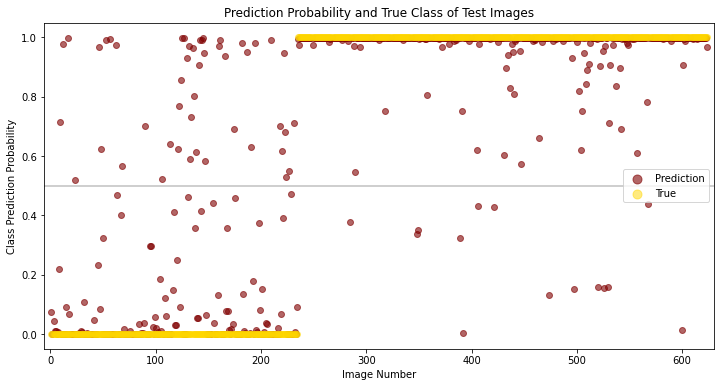

In [ ]:
# Use a scatter plot to visualize the difference between predicted and real
# classes in the test set. 

# Predictions from above are in a list of lists, this will put them in one list
#y_preds = [y for y_pred in y_preds for y in y_pred]

# Plot prediction probabilities and true classes
x = range(1, 625)
plt.figure(figsize=(12, 6))
plt.scatter(x, y_preds, color='Maroon', label='Prediction', alpha=0.6)
plt.scatter(x, y, color='Gold', label='True', alpha=0.5)
plt.hlines(0.5, -6, 630, color='gray', alpha=0.5)
plt.xlim(-6, 630)
plt.ylabel('Class Prediction Probability')
plt.xlabel('Image Number')
plt.title('Prediction Probability and True Class of Test Images')
plt.legend(markerscale=1.5)
#plt.savefig('preds-scatter.png')
#files.download('preds-scatter.png')
plt.show()

For the normal class ('0'), there are quite a few that the model was very certain were pneumonia ('1'), many fewer vice-versa. 

## Conclusions

This modeling project produced a decent model for predicting pneumonia infections using x-ray images. However, there are still many patients with pneumonia who would be missed, and quite a few normal patients who would be mis-diagnosed as well. More work would need to be done on this model to make it adequate for diagnosing patients. Additionally, including classes for origin of infection would be necessary for this model to be useful in a clinical setting. 